- (c) Ken-ichi Fukui, 2021/02/08
- MIT License

## 線形回帰によるHousingデータ住宅価格の推定
- sbs.pyを本プログラムと同じフォルダ内に配置すること

In [1]:
import numpy as np
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sbs import SBS
from sklearn.metrics import r2_score

### Boston Housingデータのロード

In [2]:
df = load_boston()
X = scale(df.data)
y = df.target
n_of_features = len(df.feature_names)

print(df.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 線形回帰＋逐次後退特徴選択（SBS）
- 学習データ，テストデータのスプリットの乱数シードを変えて，30回試行した平均を算出している

In [3]:
n_of_trials = 30 # 試行回数
n_of_selected_features = 5 # 特徴選択の特徴数の指定（特徴量名の表示のみに使用）
score_train_all = np.zeros(n_of_features) #部分集合毎の学習データに対するスコア格納用
score_test_all = np.zeros(n_of_features)  #部分集合毎のテストデータに対するスコア格納用

for k in range(0, n_of_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = k)

    lr = LinearRegression()
    sbs = SBS(lr, k_features=1, scoring=r2_score, random_state = k)
    sbs.fit(X_train, y_train)
    selected_features = list(sbs.subsets_[n_of_features - n_of_selected_features])
    print("Trial {:2d}; Best {} features: {}".format(k+1, n_of_selected_features, 
                                                     df.feature_names[selected_features]))

    #======================================================
    trn_scores, tst_scores = [], []
    for s in range(0, n_of_features):
        subset = sbs.subsets_[s]
        # 選択された特徴のindexはsubsets_に格納されている．
        X_train_sub = X_train[:, subset]
        X_test_sub = X_test[:, subset]
        lr.fit(X_train_sub, y_train)

        trn_scores.append(lr.score(X_train_sub, y_train))
        tst_scores.append(lr.score(X_test_sub, y_test))

    # trn_scores, tst_scoresは1回の試行における，特徴数毎のスコアリスト
    score_train_all += trn_scores
    score_test_all += tst_scores

Trial  1; Best 5 features: ['CHAS' 'RM' 'TAX' 'PTRATIO' 'LSTAT']
Trial  2; Best 5 features: ['RM' 'DIS' 'TAX' 'PTRATIO' 'B']
Trial  3; Best 5 features: ['RM' 'DIS' 'PTRATIO' 'B' 'LSTAT']
Trial  4; Best 5 features: ['ZN' 'DIS' 'TAX' 'PTRATIO' 'LSTAT']
Trial  5; Best 5 features: ['CRIM' 'NOX' 'RM' 'PTRATIO' 'B']
Trial  6; Best 5 features: ['RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT']
Trial  7; Best 5 features: ['CHAS' 'RM' 'DIS' 'PTRATIO' 'LSTAT']
Trial  8; Best 5 features: ['NOX' 'RM' 'DIS' 'PTRATIO' 'B']
Trial  9; Best 5 features: ['ZN' 'INDUS' 'DIS' 'TAX' 'LSTAT']
Trial 10; Best 5 features: ['NOX' 'RM' 'DIS' 'PTRATIO' 'LSTAT']
Trial 11; Best 5 features: ['CRIM' 'CHAS' 'RM' 'PTRATIO' 'LSTAT']
Trial 12; Best 5 features: ['CHAS' 'RM' 'DIS' 'PTRATIO' 'LSTAT']
Trial 13; Best 5 features: ['NOX' 'RM' 'DIS' 'PTRATIO' 'LSTAT']
Trial 14; Best 5 features: ['ZN' 'DIS' 'RAD' 'TAX' 'LSTAT']
Trial 15; Best 5 features: ['ZN' 'CHAS' 'DIS' 'TAX' 'LSTAT']
Trial 16; Best 5 features: ['CHAS' 'NOX' 'RM' 'PTRATIO' '

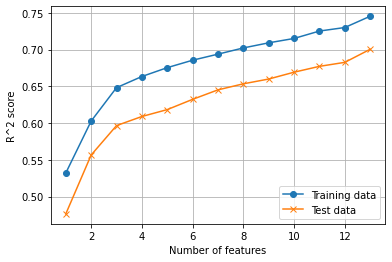

In [4]:
# 特徴数毎の平均決定係数のグラフをプロット
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, score_train_all/n_of_trials, marker='o', label="Training data")
plt.plot(k_feat, score_test_all/n_of_trials, marker='x', label="Test data")
plt.ylabel('R^2 score')
plt.xlabel('Number of features')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Lasso回帰

In [5]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]}

tst_scores_lasso = []
for k in range(0, n_of_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = k)
    gs = GridSearchCV(Lasso(), params, cv=3, scoring="r2")
    gs.fit(X_train, y_train)
    print("#{:2d} best validation score:{:.3f}, best param:{}".format(k+1, gs.best_score_, gs.best_params_))
    
    # ベストパラメータで再学習しテストデータに適用
    lasso = Lasso(alpha=gs.best_params_['alpha'])
    lasso.fit(X_train, y_train)
    tst_scores_lasso.append(lasso.score(X_test, y_test))

# 1 best validation score:0.724, best param:{'alpha': 0.01}
# 2 best validation score:0.707, best param:{'alpha': 0.01}
# 3 best validation score:0.711, best param:{'alpha': 0.0001}
# 4 best validation score:0.682, best param:{'alpha': 0.01}
# 5 best validation score:0.733, best param:{'alpha': 0.0001}
# 6 best validation score:0.682, best param:{'alpha': 0.01}
# 7 best validation score:0.703, best param:{'alpha': 0.001}
# 8 best validation score:0.744, best param:{'alpha': 0.01}
# 9 best validation score:0.691, best param:{'alpha': 0.01}
#10 best validation score:0.678, best param:{'alpha': 0.0001}
#11 best validation score:0.719, best param:{'alpha': 0.01}
#12 best validation score:0.718, best param:{'alpha': 0.01}
#13 best validation score:0.693, best param:{'alpha': 0.0001}
#14 best validation score:0.675, best param:{'alpha': 0.1}
#15 best validation score:0.722, best param:{'alpha': 0.0001}
#16 best validation score:0.710, best param:{'alpha': 0.1}
#17 best validation score:0.726

In [6]:
print("Ave. test accuracy: {:.3f}".format(np.mean(tst_scores_lasso)))

Ave. test accuracy: 0.700


### SVR

In [7]:
from sklearn.svm import SVR

params = {'gamma':[0.01, 0.05, 0.1], 'epsilon':[0.01, 0.1, 1.0], 'C':[10.0, 100.0, 1000.0]}

tst_scores_svr= []
for k in range(0, n_of_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = k)
    gs = GridSearchCV(SVR(kernel='rbf'), params, cv=3, scoring="r2")
    gs.fit(X_train, y_train)
    print("#{:2d} best validation score:{:.3f}, best param:{}".format(k+1, gs.best_score_, gs.best_params_))
    
    # ベストパラメータで再学習しテストデータに適用
    svr = SVR(kernel='rbf', gamma=gs.best_params_['gamma'], epsilon=gs.best_params_['epsilon'], C=gs.best_params_['C'])
    svr.fit(X_train, y_train)
    tst_scores_svr.append(svr.score(X_test, y_test))

# 1 best validation score:0.838, best param:{'C': 100.0, 'epsilon': 0.1, 'gamma': 0.01}
# 2 best validation score:0.838, best param:{'C': 100.0, 'epsilon': 0.01, 'gamma': 0.05}
# 3 best validation score:0.826, best param:{'C': 100.0, 'epsilon': 1.0, 'gamma': 0.05}
# 4 best validation score:0.807, best param:{'C': 100.0, 'epsilon': 1.0, 'gamma': 0.05}
# 5 best validation score:0.843, best param:{'C': 100.0, 'epsilon': 1.0, 'gamma': 0.05}
# 6 best validation score:0.844, best param:{'C': 100.0, 'epsilon': 1.0, 'gamma': 0.05}
# 7 best validation score:0.837, best param:{'C': 100.0, 'epsilon': 1.0, 'gamma': 0.05}
# 8 best validation score:0.870, best param:{'C': 1000.0, 'epsilon': 1.0, 'gamma': 0.01}
# 9 best validation score:0.824, best param:{'C': 100.0, 'epsilon': 0.01, 'gamma': 0.01}
#10 best validation score:0.833, best param:{'C': 100.0, 'epsilon': 1.0, 'gamma': 0.05}
#11 best validation score:0.835, best param:{'C': 1000.0, 'epsilon': 1.0, 'gamma': 0.05}
#12 best validation score:0.

In [8]:
print("Ave. test accuracy: {:.3f}".format(np.mean(tst_scores_svr)))

Ave. test accuracy: 0.841
